In [25]:
import gym

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchbnn as bnn

import sklearn
from sklearn.metrics import mean_squared_error, r2_score

import pickle

import os



In [26]:
torch.cuda.empty_cache()

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(device)

cuda


In [27]:
class EnsembleModel(nn.Module):
    def __init__(self, input_size, output_size, num_layers, num_nodes, activation, num_ensembles):
        super(EnsembleModel, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.num_nodes = num_nodes
        self.activation = activation
        self.num_ensembles = num_ensembles

        self.ensemble_models = nn.ModuleList()
        for _ in range(num_ensembles):
            model = self._build_model()
            self.ensemble_models.append(model)

    def _build_model(self):
        layers = []
        layers.append(nn.Linear(self.input_size, self.num_nodes))
        layers.append(self.activation)

        for _ in range(self.num_layers - 1):
            layers.append(nn.Linear(self.num_nodes, self.num_nodes))
            layers.append(self.activation)

        layers.append(nn.Linear(self.num_nodes, self.output_size))
        return nn.Sequential(*layers)

    def forward(self, x):
        means = []
        stds = []
        for model in self.ensemble_models:
            output = model(x)
            mean = output[:, :self.output_size // 2]
            std = torch.exp(output[:, self.output_size // 2:])
            means.append(mean)
            stds.append(std)
        means = torch.stack(means, dim=0)
        stds = torch.stack(stds, dim=0)
        final_mean = torch.mean(means, dim=0)
        final_std = torch.mean(stds, dim=0)
        return final_mean, final_std
    
# Loss function
def gaussian_likelihood(mean_pred, std_pred, target):
    EPS = 1e-6 
    std_pred = torch.clamp(std_pred, min=EPS) 
    
    # Negative log likelihood of Gaussian distribution
    loss = torch.mean(0.5 * ((target - mean_pred) / std_pred) ** 2 + torch.log(std_pred) + 0.5 * np.log(2 * np.pi))
    
    if torch.isnan(loss):
#         print('target: ',target,' mean: ', mean_pred, ' std: ',std_pred)
        print('mean: ', mean_pred, ' std: ',std_pred)
    return loss

In [28]:
class MC_Dropout_Net(nn.Module):
    def __init__(self, input_size, output_size, num_hidden_layers, hidden_layer_nodes, activation, dropout_prob, num_network):
        super(MC_Dropout_Net, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.num_hidden_layers = num_hidden_layers
        self.hidden_layer_nodes = hidden_layer_nodes
        self.activation = activation
        self.num_network = num_network
        
        # Define the layers
        self.input_layer = nn.Linear(input_size, hidden_layer_nodes)
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden_layers):
            self.hidden_layers.append(nn.Linear(hidden_layer_nodes, hidden_layer_nodes))
            self.hidden_layers.append(nn.Dropout(p=dropout_prob))
        self.output_layer = nn.Linear(hidden_layer_nodes, output_size)

    def forward(self, x):
        total_output = 0.0
        for i in range(self.num_network):
            x_temp = x
            x_temp = self.activation(self.input_layer(x_temp))
            for hidden_layer in self.hidden_layers:
                x_temp = self.activation(hidden_layer(x_temp))
            output = self.output_layer(x_temp)
            total_output += output
        average_output = total_output / self.num_network
        return average_output


In [29]:
class BayesianNN(nn.Module):
    def __init__(self, input_size, output_size, num_hidden_layers, hidden_layer_nodes, activation):
        super(BayesianNN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.num_hidden_layers = num_hidden_layers
        self.hidden_layer_nodes = hidden_layer_nodes
        self.activation = activation
        
        # Define the layers
#         self.input_layer = nn.Linear(input_size, hidden_layer_nodes)
        self.input_layer = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=input_size, out_features=hidden_layer_nodes)
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden_layers):
#           self.hidden_layers.append(nn.Linear(hidden_layer_nodes, hidden_layer_nodes))
            self.hidden_layers.append(bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=hidden_layer_nodes, out_features=hidden_layer_nodes))
#        self.output_layer = nn.Linear(hidden_layer_nodes, output_size)
        self.output_layer = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=hidden_layer_nodes, out_features=output_size)
        

    def forward(self, x):
        x = self.activation(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))
        output = self.output_layer(x)
        return output


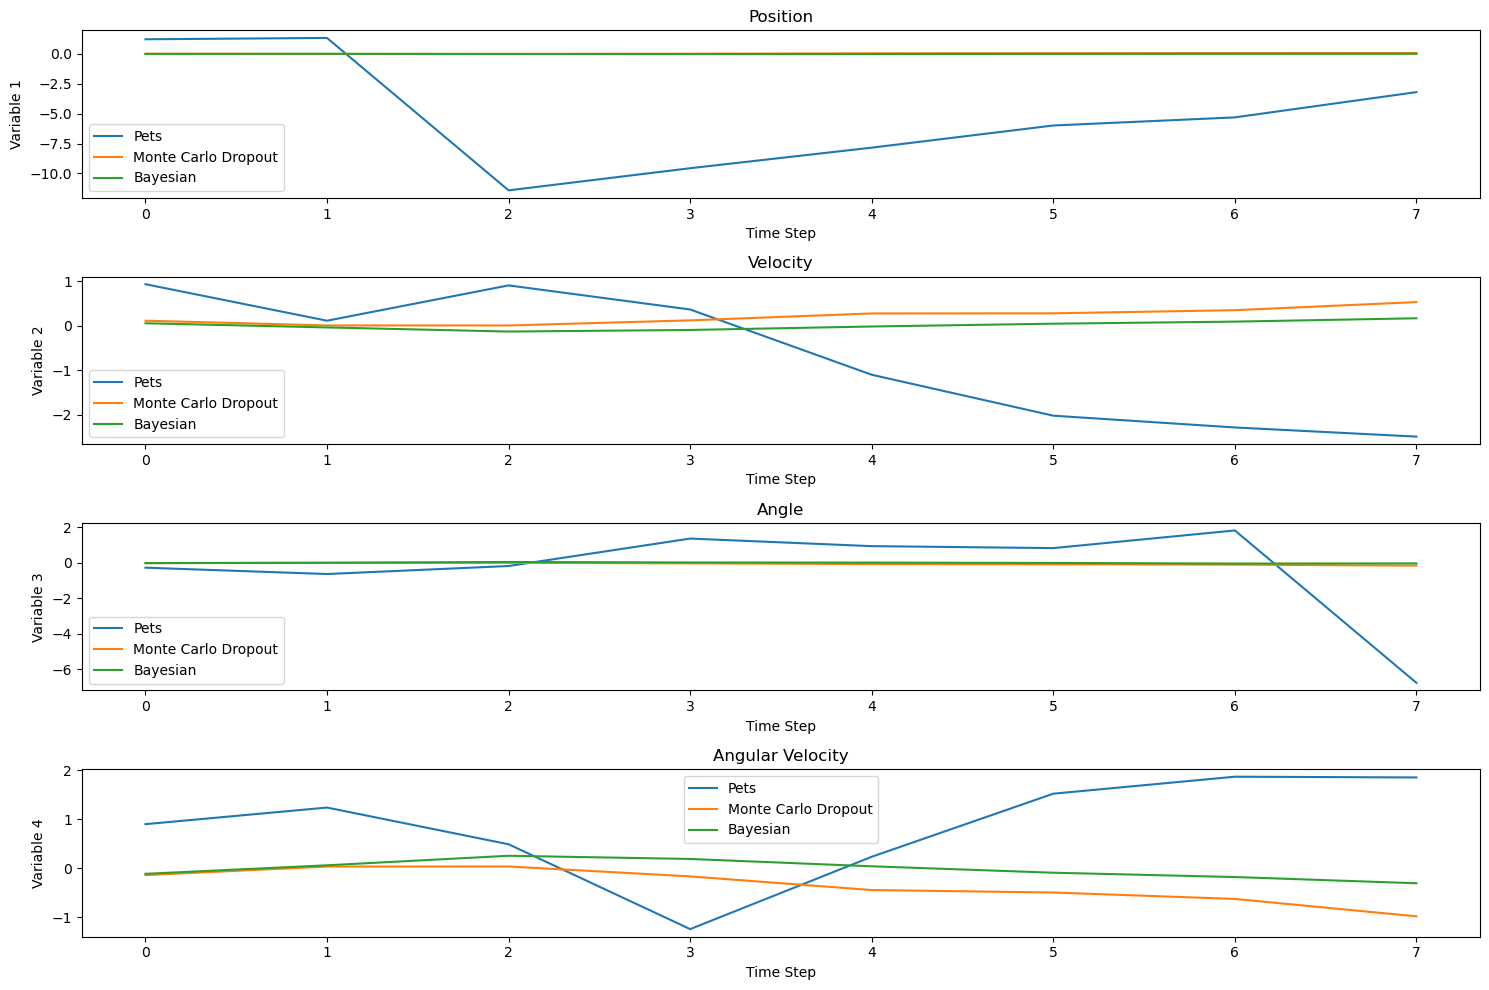

In [32]:
env_names = ['CartPole-v1', 'MountainCarContinuous-v0', 'MountainCar-v0', 'Pendulum-v1']
num_samples_list = ['10k', '20k', '30k', '40k', '50k']

for env_name in env_names:

    env = gym.make(env_name)
    batch_size = 32


    for num_samples in num_samples_list:
        
        #Initialize parameters for model
        action = env.action_space.sample()
        
        if isinstance(action, int):
            input_size = env.observation_space.shape[0] + 1
        elif isinstance(action, np.ndarray):
            input_size = env.observation_space.shape[0] + len(action)

        output_size = 2*(env.observation_space.shape[0] + 2)
        num_layers = 3
        num_nodes = 20
        activation = nn.ReLU()
        num_ensembles = 5
        learning_rate = 0.01

        pets_model = EnsembleModel(input_size, output_size, num_layers, num_nodes, activation, num_ensembles).to(device)
        
#         pets_model_weights_file_path = 'pets_'+ env_name + '_' + num_samples +'.pth' 
        pets_model_weights_file_path = 'pets_'+ env_name + '_' + num_samples +'_g=5.pth' 
        pets_model.load_state_dict(torch.load(pets_model_weights_file_path))

        if isinstance(action, int):
            input_size = env.observation_space.shape[0] + 1
        elif isinstance(action, np.ndarray):
            input_size = env.observation_space.shape[0] + len(action)

        output_size = env.observation_space.shape[0] + 2
        num_hidden_layers = 3
        hidden_layer_nodes = 20
        activation = F.relu
        learning_rate = 0.01
        dropout_prob = 0.3
        num_networks = 1


        # Instantiate the model
        monte_carlo_model = MC_Dropout_Net(input_size, output_size, num_hidden_layers, hidden_layer_nodes, activation, dropout_prob, num_networks).to(device)
        
#         monte_carlo_model_weights_file_path = 'montecarlodropout_'+ env_name + '_' + num_samples +'.pth' 
        monte_carlo_model_weights_file_path = 'montecarlodropout_'+ env_name + '_' + num_samples +'_g=5.pth' 
        # Save the trained model
        monte_carlo_model.load_state_dict(torch.load(monte_carlo_model_weights_file_path))

        if isinstance(action, int):
            input_size = env.observation_space.shape[0] + 1
        elif isinstance(action, np.ndarray):
            input_size = env.observation_space.shape[0] + len(action)

        output_size = env.observation_space.shape[0] + 2
        num_hidden_layers = 3
        hidden_layer_nodes = 20
        activation = F.relu
        learning_rate = 0.01
        dropout_prob = 0.3
        num_networks = 5

        # Instantiate the model
        bayesian_model = BayesianNN(input_size, output_size, num_hidden_layers, hidden_layer_nodes, activation).to(device)
        
#         bayesian_model_weights_file_path = 'bayesian_'+ env_name + '_' + num_samples +'.pth' 
        bayesian_model_weights_file_path = 'bayesian_'+ env_name + '_' + num_samples +'_g=5.pth' 
        # Save the trained model
        bayesian_model.load_state_dict(torch.load(bayesian_model_weights_file_path))
#         torch.load(model.state_dict(), model_weights_file_path)
        
#         env.observation_space.shape[0]
        state_var = [[]]
                    
        num_models = 3
        num_steps = 8  # Number of steps in an episode
        num_state_vars = 4  # Number of state variables

        # Initialize the state for each model
        initial_state = env.reset()[0] # Example initial state
        states_over_time = np.zeros((num_models, num_steps, num_state_vars))

        get_action = [env.action_space.sample() for i in range(num_steps)]
        state = initial_state
        for t in range(num_steps):
            action = get_action[t]
            input_model = list(state) + [action]
            input_model = torch.tensor(input_model, device=device, dtype=torch.float32)
            input_model = input_model.unsqueeze(0)

            #print(f"Model is on device: " + str(next(model.parameters()).device))
            #print(f"input_model is on device: {input_model.device}")
            mean_next_state, std_next_state = pets_model(input_model)

            # Apply softplus to std_next_state to ensure it is positive
            std_next_state = torch.nn.functional.softplus(std_next_state)

            std_next_state = torch.clamp(std_next_state, min = 0, max=1e+2)

            # Create a normal distribution with the given mean and std
            normal_dist = torch.distributions.Normal(mean_next_state, std_next_state)

            # Sample from the distribution
            next_state = normal_dist.sample()[0]

            #print(next_state)
            state = list(state)
            action = [str(action)]
            next_state = next_state.tolist()
            next_state, reward, done = next_state[:-2], next_state[-2], next_state[-1]
            reward = [reward]
            #next_state = [noise*random.uniform(-1, 1)+next_state[i] for i in range(state_size)]
            #next_state = self.add_noise(next_state)
            states_over_time[0, t] = next_state
            state = next_state
        
        state = initial_state
        for t in range(num_steps):
            action = get_action[t]
            input_model = list(state) + [action]
            input_model = torch.tensor(input_model, device=device, dtype=torch.float32)
            #print(f"Model is on device: " + str(next(model.parameters()).device))
            #print(f"input_model is on device: {input_model.device}")
            next_state = monte_carlo_model(input_model)
            state = list(state)
            action = [str(action)]
            next_state = next_state.tolist()
            next_state, reward, done = next_state[:-2], next_state[-2], next_state[-1]
            reward = [reward]
            #next_state = [noise*random.uniform(-1, 1)+next_state[i] for i in range(state_size)]
            #next_state = self.add_noise(next_state)
            states_over_time[1, t] = next_state
            state = next_state
            
        state = initial_state
        for t in range(num_steps):
            action = get_action[t]
            input_model = list(state) + [action]
            input_model = torch.tensor(input_model, device=device, dtype=torch.float32)
            #print(f"Model is on device: " + str(next(model.parameters()).device))
            #print(f"input_model is on device: {input_model.device}")
            next_state = bayesian_model(input_model)
            state = list(state)
            action = [str(action)]
            next_state = next_state.tolist()
            next_state, reward, done = next_state[:-2], next_state[-2], next_state[-1]
            reward = [reward]
            #next_state = [noise*random.uniform(-1, 1)+next_state[i] for i in range(state_size)]
            #next_state = self.add_noise(next_state)
            states_over_time[2, t] = next_state
            state = next_state     
        
        # Plotting
        
        model_name = ['Pets', 'Monte Carlo Dropout', 'Bayesian']
        state_var_name = ['Position', 'Velocity', 'Angle', 'Angular Velocity']
        plt.figure(figsize=(15, 10))
        for var in range(num_state_vars):
            plt.subplot(num_state_vars, 1, var + 1)
            for i in range(num_models):
                plt.plot(states_over_time[i, :, var], label=model_name[i])
            plt.title(state_var_name[var])
            plt.xlabel('Time Step')
            plt.ylabel(f'Variable {var+1}')
            plt.legend()
#             plt.savefig(f'state_variable_{var+1}.png')
        plt.tight_layout()
#         plt.savefig(env_name + '_' + num_samples + '_state_variables_over_time.png')
        plt.savefig(env_name + '_' + num_samples + '_g=5_state_variables_over_time.png')
        plt.show()
        
        break
    break